In [1]:
import string
import re
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
import nltk

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
def load_doc(filename):
# open the file as read only
  file = open(filename, 'r')
# read all text
  text = file.read()
# close the file
  file.close()
  return text

In [138]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [139]:
with open('/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/My Drive/foo.txt'

Hello Google Drive!

In [6]:
def clean_doc(doc):
# split into tokens by white space
  tokens = doc.split()
# prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
# remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
# remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]
# filter out stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1]
  return tokens

In [7]:
# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
# load doc
  doc = load_doc(filename)
# clean doc
  tokens = clean_doc(doc)
# update counts
  vocab.update(tokens)

In [10]:
# load all docs in a directory
def process_docs(directory, vocab):
# walk through all files in the folder
   for filename in listdir(directory):
# skip any reviews in the test set
     if filename.startswith('cv9'):
       continue
# cre ate the full path of the file to open
     path = directory + '/' + filename
# add doc to vocab
     add_doc_to_vocab(path, vocab)

In [11]:
# define vocab
vocab = Counter()
# add all docs to vocab
process_docs('/gdrive/My Drive/datasets/txt_sentoken/pos', vocab)
process_docs('/gdrive/My Drive/datasets/txt_sentoken/neg', vocab)
# print the size of the vocab
print(len(vocab))
# print the top words in the vocab
print(vocab.most_common(50))


44276
[('film', 7983), ('one', 4946), ('movie', 4826), ('like', 3201), ('even', 2262), ('good', 2080), ('time', 2041), ('story', 1907), ('films', 1873), ('would', 1844), ('much', 1824), ('also', 1757), ('characters', 1735), ('get', 1724), ('character', 1703), ('two', 1643), ('first', 1588), ('see', 1557), ('way', 1515), ('well', 1511), ('make', 1418), ('really', 1407), ('little', 1351), ('life', 1334), ('plot', 1288), ('people', 1269), ('could', 1248), ('bad', 1248), ('scene', 1241), ('movies', 1238), ('never', 1201), ('best', 1179), ('new', 1140), ('scenes', 1135), ('man', 1131), ('many', 1130), ('doesnt', 1118), ('know', 1092), ('dont', 1086), ('hes', 1024), ('great', 1014), ('another', 992), ('action', 985), ('love', 977), ('us', 967), ('go', 952), ('director', 948), ('end', 946), ('something', 945), ('still', 936)]


In [16]:
min_occurane = 2
tokens = [k for k,c in vocab.items() if c >= min_occurane]
print(len(tokens))


25767


In [19]:
# save list to file
def save_list(lines, filename):
# convert lines to a single blob of text
  data = '\n'.join(lines)
# open file
  file = open(filename, 'w')
# write text
  file.write(data)
# close file
  file.close()
# save tokens to a vocabulary file
save_list(tokens, '/gdrive/My Drive/datasets/txt_sentoken/vocab.txt')

In [20]:
def doc_to_line(filename, vocab):
# load the doc
   doc = load_doc(filename)
# clean doc
   tokens = clean_doc(doc)
# filter by vocab
   tokens = [w for w in tokens if w in vocab]
   return ' '.join(tokens)

In [35]:
# load all docs in a directory
def process_docs(directory, vocab, is_train):
  lines = list()
# walk through all files in the folder
  for filename in listdir(directory):
# skip any reviews in the test set
    if is_train and filename.startswith('cv9'):
      continue
    if not is_train and not filename.startswith('cv9'):
      continue
# create the full path of the file to open
    path = directory + '/' + filename
# load and clean the doc
    line = doc_to_line(path, vocab)
# add to list
    lines.append(line)
  return lines

In [28]:
# load and clean a dataset
def load_clean_dataset(vocab,is_train):
# load documents
  neg = process_docs('/gdrive/My Drive/datasets/txt_sentoken/neg', vocab,is_train)
  pos = process_docs('/gdrive/My Drive/datasets/txt_sentoken/pos', vocab,is_train)
  docs = neg + pos
# prepare labels
  labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
  return docs, labels

In [32]:
from keras.preprocessing.text import Tokenizer
def create_tokenizer(lines):
   tokenizer = Tokenizer()
   tokenizer.fit_on_texts(lines)
   return tokenizer

In [121]:
vocab_filename = '/gdrive/My Drive/datasets/txt_sentoken/vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

In [36]:
# load all training reviews
docs, labels = load_clean_dataset(vocab,True)

In [37]:
print(len(docs), len(labels))

1800 1800


In [38]:
train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab, False)
# create the tokenizer
tokenizer = create_tokenizer(train_docs)
# encode data
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq')
Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq')
print(Xtrain.shape, Xtest.shape)

(1800, 25768) (200, 25768)


In [42]:
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense

In [43]:
n_words = Xtest.shape[1]

In [67]:
# define the model
def define_model(n_words):
# define network
  model = Sequential()
  model.add(Dense(512, input_shape=(n_words,), activation='relu'))
  model.add(Dense(128,activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
# compile network
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize defined model
  model.summary()
  plot_model(model, to_file='model.png', show_shapes=True)
  return model

In [68]:
model=define_model(n_words)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               13193728  
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 13,259,521
Trainable params: 13,259,521
Non-trainable params: 0
_________________________________________________________________


In [69]:
import numpy as np

In [70]:
Xtrain=np.array(Xtrain)

In [71]:
ytrain=np.array(ytrain)

In [72]:
ytest=np.array(ytest)

In [73]:
model.fit(Xtrain, ytrain, epochs=10, verbose=2)

Epoch 1/10
57/57 - 4s - loss: 0.6850 - accuracy: 0.5956
Epoch 2/10
57/57 - 4s - loss: 0.5160 - accuracy: 0.8389
Epoch 3/10
57/57 - 4s - loss: 0.1615 - accuracy: 0.9806
Epoch 4/10
57/57 - 4s - loss: 0.0393 - accuracy: 0.9972
Epoch 5/10
57/57 - 4s - loss: 0.0122 - accuracy: 1.0000
Epoch 6/10
57/57 - 4s - loss: 0.0062 - accuracy: 1.0000
Epoch 7/10
57/57 - 4s - loss: 0.0039 - accuracy: 1.0000
Epoch 8/10
57/57 - 4s - loss: 0.0027 - accuracy: 1.0000
Epoch 9/10
57/57 - 4s - loss: 0.0020 - accuracy: 1.0000
Epoch 10/10
57/57 - 4s - loss: 0.0015 - accuracy: 1.0000


In [74]:
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 91.000003


In [86]:
def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
  scores = list()
  n_repeats = 10
  n_words = Xtest.shape[1]
  for i in range(n_repeats):
# define network
#     model = Sequential()
#     model.add(Dense(50, input_shape=(n_words,), activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
# # compile network
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model=define_model(n_words)
# fit network
    model.fit(Xtrain, ytrain, epochs=10, verbose=0)
# evaluate
    loss, acc = model.evaluate(Xtest, ytest, verbose=0)
    scores.append(acc)
    print('%d accuracy: %s' % ((i+1), acc))
  return scores

In [77]:
evaluate_mode(Xtrain, ytrain, Xtest, ytest)

Epoch 1/10
57/57 - 1s - loss: 0.6914 - accuracy: 0.5161
Epoch 2/10
57/57 - 1s - loss: 0.6812 - accuracy: 0.5711
Epoch 3/10
57/57 - 1s - loss: 0.6633 - accuracy: 0.6572
Epoch 4/10
57/57 - 1s - loss: 0.6363 - accuracy: 0.8100
Epoch 5/10
57/57 - 1s - loss: 0.5999 - accuracy: 0.9094
Epoch 6/10
57/57 - 1s - loss: 0.5578 - accuracy: 0.9378
Epoch 7/10
57/57 - 1s - loss: 0.5125 - accuracy: 0.9506
Epoch 8/10
57/57 - 1s - loss: 0.4679 - accuracy: 0.9556
Epoch 9/10
57/57 - 1s - loss: 0.4255 - accuracy: 0.9661
Epoch 10/10
57/57 - 1s - loss: 0.3840 - accuracy: 0.9661
1 accuracy: 0.8700000047683716
Epoch 1/10
57/57 - 1s - loss: 0.6915 - accuracy: 0.6022
Epoch 2/10
57/57 - 1s - loss: 0.6819 - accuracy: 0.7511
Epoch 3/10
57/57 - 1s - loss: 0.6644 - accuracy: 0.8906
Epoch 4/10
57/57 - 1s - loss: 0.6384 - accuracy: 0.9028
Epoch 5/10
57/57 - 1s - loss: 0.6045 - accuracy: 0.9328
Epoch 6/10
57/57 - 1s - loss: 0.5655 - accuracy: 0.9294
Epoch 7/10
57/57 - 1s - loss: 0.5237 - accuracy: 0.9472
Epoch 8/10
57/57

Exception ignored in: <bound method IteratorResourceDeleter.__del__ of <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter object at 0x7ff6e31b7208>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 537, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1279, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


Epoch 1/10
57/57 - 1s - loss: 0.6918 - accuracy: 0.5211
Epoch 2/10
57/57 - 1s - loss: 0.6834 - accuracy: 0.8744
Epoch 3/10
57/57 - 1s - loss: 0.6649 - accuracy: 0.8889
Epoch 4/10
57/57 - 1s - loss: 0.6338 - accuracy: 0.9222
Epoch 5/10
57/57 - 1s - loss: 0.5934 - accuracy: 0.9200
Epoch 6/10
57/57 - 1s - loss: 0.5485 - accuracy: 0.9411
Epoch 7/10
57/57 - 1s - loss: 0.5011 - accuracy: 0.9494
Epoch 8/10
57/57 - 1s - loss: 0.4533 - accuracy: 0.9539
Epoch 9/10
57/57 - 1s - loss: 0.4091 - accuracy: 0.9628
Epoch 10/10
57/57 - 1s - loss: 0.3670 - accuracy: 0.9667
30 accuracy: 0.8700000047683716


[0.8700000047683716,
 0.8700000047683716,
 0.8650000095367432,
 0.875,
 0.8700000047683716,
 0.8700000047683716,
 0.8700000047683716,
 0.8650000095367432,
 0.8700000047683716,
 0.8650000095367432,
 0.875,
 0.8700000047683716,
 0.8700000047683716,
 0.875,
 0.8700000047683716,
 0.8650000095367432,
 0.8799999952316284,
 0.8700000047683716,
 0.875,
 0.8600000143051147,
 0.875,
 0.8799999952316284,
 0.8700000047683716,
 0.8700000047683716,
 0.8650000095367432,
 0.8849999904632568,
 0.8700000047683716,
 0.8650000095367432,
 0.8650000095367432,
 0.8700000047683716]

In [78]:
def prepare_data(train_docs, test_docs, mode):
# create the tokenizer
  tokenizer = Tokenizer()
# fit the tokenizer on the documents
  tokenizer.fit_on_texts(train_docs)
# encode training data set
  Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
# encode training data set
  Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
  return Xtrain, Xtest

In [79]:
from pandas import DataFrame
from matplotlib import pyplot

In [87]:
# run experiment
modes = ['binary', 'count', 'tfidf', 'freq']
results = DataFrame()
for mode in modes:
  print(mode)
# prepare data for mode
  Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)
# evaluate model on data for mode
  results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)
# summarize results
print(results.describe())

binary
Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_176 (Dense)            (None, 512)               13193728  
_________________________________________________________________
dense_177 (Dense)            (None, 128)               65664     
_________________________________________________________________
dense_178 (Dense)            (None, 1)                 129       
Total params: 13,259,521
Trainable params: 13,259,521
Non-trainable params: 0
_________________________________________________________________
1 accuracy: 0.9150000214576721
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_179 (Dense)            (None, 512)               13193728  
_________________________________________________________________
dense_180 (Dense)            (None, 128)      

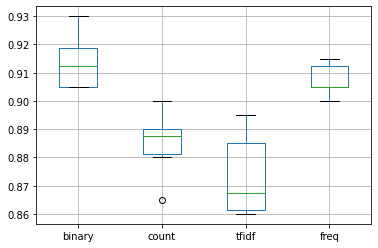

In [88]:
results.boxplot()
pyplot.show()

```model 1
  binary      count      tfidf       freq
count  10.000000  10.000000  10.000000  10.000000
mean    0.928000   0.903000   0.877500   0.868000
std     0.007149   0.006325   0.011365   0.004216
min     0.915000   0.890000   0.860000   0.865000
25%     0.922500   0.901250   0.871250   0.865000
50%     0.930000   0.905000   0.875000   0.865000
75%     0.933750   0.905000   0.887500   0.870000
max     0.935000   0.910000   0.895000   0.875000
```

In [147]:
def predict_sentiment(review_file, vocab, tokenizer, model):
# clean
  review=load_doc(review_file)
  tokens = clean_doc(review)
# filter by vocab
  tokens = [w for w in tokens if w in vocab]
# convert to line
  line = ' '.join(tokens)
# encode
  encoded = tokenizer.texts_to_matrix([line], mode='binary')
# predict sentiment
  yhat = model.predict(encoded, verbose=0)
# retrieve predicted percentage and label
  percent_pos = yhat[0,0]
  print(percent_pos)
  if round(percent_pos) == 0:
    return (1-percent_pos), 'NEGATIVE'
  return percent_pos, 'POSITIVE'

In [115]:
review="I won't say this is the most overrated movie ever made. There are many movies which are considered among the best ever by the majority of people that are as overrated as this one is. However, that this is one of the most overrated of all time, no one can deny that. I hate westerns. However, considering the fame of this one, the fact that it is in most lists of the all time's greatest movies, the fact of being a Spanish-Italian production and the value that most people give it (including this guy who is a friend of mine, who owns the movie and loaned it to me), I decided to give it a look, even though its long runtime could easily scare me off. I know that its Italian title is 'Il buono, il brutto, il cattivo', but I don't know if it was filmed in English language and later dubbed in Italian or the contrary, although I believe it was filmed in English. This spaghetti western was directed by Sergio Leone and stars Clint Eastwood as Blondie (The Good), Lee Van Cleef as Angel Eyes (The Bad) and Eli Wallach as Tuco (The Ugly). To be frank, the character Tuco annoyed me very much, not to mention that he was worst than snakes. Angel Eyes was nowhere near as annoying, being a more likable character in comparison. Blondie is a more complicated character. He's supposed to be the good guy yet he teams with Tuco during most of the movie and actually saves him twice from his execution rope (including in the end, when he was supposed to kill him). He kills Angel Eyes, yet he doesn't kill Tuco - and after everything that Tuco did to him. He is not that good after all... There's some good in this movie but I saw far more of bad and ugly in it. There is brutal violence in this. Plus, the movie is way too long. And it doesn't really offer much during its runtime of nearly 3 hours. Certain sequences were filmed in a way that strongly resembles me '2001: A Space Odyssey'. The first 9-10 minutes are a good example of this. The opening is long and has music, there is no dialog, the slow pace of the scenes gives us time to appreciate the scenario. Another good example of this is the Mexican standoff scene that lasts 5 minutes near the ending when the 3 main characters stare each other down in the graveyard's circular center, calculating alliances and dangers (and the amazing distance which the camera films it). The famous film score by Ennio Morricone (who is a genius, like John Williams) is phenomenal, especially the spectacular and unforgettable main theme. But the music that plays when Tuco is running in the Sad Hill cemetery is equally memorable. I didn't know that this movie was part of a trilogy, much less that it was the 3rd one. I also thought it was from the 50's, not the 60's. Anyway, none of that matters. This movie didn't do anything for me. Is this one of the all time's greatest movies? Absolutely not!"

In [150]:
review_file= '/gdrive/My Drive/datasets/txt_sentoken/review.txt'


In [154]:
predict_sentiment(review_file,vocab,tokenizer,model)

1.0


(1.0, 'POSITIVE')